In [1]:
import pandas as pd

In [2]:
# Load the dataset

df = pd.read_csv("forex_1year.csv")

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6235 entries, 0 to 6234
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6235 non-null   object 
 1   clock          6235 non-null   object 
 2   open_eurusd    6235 non-null   float64
 3   high_eurusd    6235 non-null   float64
 4   low_eurusd     6235 non-null   float64
 5   close_eurusd   6235 non-null   float64
 6   tikvol_eurusd  6235 non-null   int64  
 7   open_audusd    6235 non-null   float64
 8   high_audusd    6235 non-null   float64
 9   low_audusd     6235 non-null   float64
 10  close_audusd   6235 non-null   float64
 11  tikvol_audusd  6235 non-null   int64  
 12  open_eurgbp    6235 non-null   float64
 13  high_eurgbp    6235 non-null   float64
 14  low_eurgbp     6235 non-null   float64
 15  close_eurgbp   6235 non-null   float64
 16  tikvol_eurgbp  6235 non-null   int64  
 17  open_gbpusd    6235 non-null   float64
 18  high_gbp

(None,
          date     clock  open_eurusd  high_eurusd  low_eurusd  close_eurusd  \
 0  2023.04.24  00:00:00      1.09883      1.09904     1.09861       1.09863   
 1  2023.04.24  01:00:00      1.09868      1.09928     1.09862       1.09921   
 2  2023.04.24  02:00:00      1.09921      1.09956     1.09906       1.09913   
 3  2023.04.24  03:00:00      1.09913      1.09945     1.09839       1.09943   
 4  2023.04.24  04:00:00      1.09944      1.09944     1.09864       1.09869   
 
    tikvol_eurusd  open_audusd  high_audusd  low_audusd  ...  open_usdchf  \
 0            552      0.66947      0.66968     0.66906  ...      1.09883   
 1            704      0.66932      0.66967     0.66885  ...      1.09868   
 2            625      0.66945      0.66971     0.66903  ...      1.09921   
 3           1451      0.66902      0.66948     0.66817  ...      1.09913   
 4           1713      0.66944      0.66948     0.66818  ...      1.09944   
 
    high_usdchf  low_usdchf  close_usdchf  tikv

In [3]:
import numpy as np

# Combine date and clock into datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['clock'], format='%Y.%m.%d %H:%M:%S')
df.set_index('datetime', inplace=True)

# Calculate log returns for EUR/USD
df['log_return'] = np.log(df['close_eurusd'] / df['close_eurusd'].shift(1))

# Calculate rolling volatility (standard deviation of log returns over 24-hour window)
df['volatility'] = df['log_return'].rolling(window=24).std()

# Drop NA values generated by shifting/rolling
df_clean = df.dropna(subset=['log_return', 'volatility'])

df_clean[['close_eurusd', 'log_return', 'volatility']].head()


,close_eurusd,log_return,volatility
datetime,,,
2023-04-25 00:00:00,1.10455,0.000127,0.000807
2023-04-25 01:00:00,1.10504,0.000444,0.000806
2023-04-25 02:00:00,1.10565,0.000552,0.000806
2023-04-25 03:00:00,1.10587,0.000199,0.000806
2023-04-25 04:00:00,1.10564,-0.000208,0.000789


In [4]:
# Check data loss at each step
initial_rows = len(df_clean)

# Add features with slightly smaller windows to preserve more rows
def add_technical_indicators_optimized(df):
    df = df.copy()
    df['ma_3'] = df['close_eurusd'].rolling(window=3).mean()
    df['ma_6'] = df['close_eurusd'].rolling(window=6).mean()

    # Bollinger Bands
    rolling_mean = df['close_eurusd'].rolling(window=10).mean()
    rolling_std = df['close_eurusd'].rolling(window=10).std()
    df['bollinger_upper'] = rolling_mean + 2 * rolling_std
    df['bollinger_lower'] = rolling_mean - 2 * rolling_std

    # RSI with shorter window
    delta = df['close_eurusd'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=7).mean()
    avg_loss = pd.Series(loss).rolling(window=7).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # Lag features
    df['lag_return_1'] = df['log_return'].shift(1)
    df['lag_volatility_1'] = df['volatility'].shift(1)

    return df

# Apply the optimized feature set
df_temp = add_technical_indicators_optimized(df_clean)
final_df = df_temp.dropna()

final_rows = len(final_df)
initial_rows, final_rows, final_df[['volatility', 'ma_3', 'bollinger_upper', 'rsi']].head()


(6211,
 0,
 Empty DataFrame
 Columns: [volatility, ma_3, bollinger_upper, rsi]
 Index: [])

In [5]:
# Final feature set computation with correct assignment
df_final = df_clean.copy()

# Moving averages
df_final['ma_3'] = df_final['close_eurusd'].rolling(window=3).mean()
df_final['ma_6'] = df_final['close_eurusd'].rolling(window=6).mean()

# Bollinger Bands
rolling_mean = df_final['close_eurusd'].rolling(window=10).mean()
rolling_std = df_final['close_eurusd'].rolling(window=10).std()
df_final['bollinger_upper'] = rolling_mean + 2 * rolling_std
df_final['bollinger_lower'] = rolling_mean - 2 * rolling_std

# RSI (correctly attached)
delta = df_final['close_eurusd'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=df_final.index).rolling(window=7).mean()
avg_loss = pd.Series(loss, index=df_final.index).rolling(window=7).mean()
rs = avg_gain / avg_loss
df_final['rsi'] = 100 - (100 / (1 + rs))

# Lag features
df_final['lag_return_1'] = df_final['log_return'].shift(1)
df_final['lag_volatility_1'] = df_final['volatility'].shift(1)

# Drop rows with any NaNs now
df_model = df_final.dropna()

df_model[['volatility', 'ma_3', 'bollinger_upper', 'rsi']].head()

,volatility,ma_3,bollinger_upper,rsi
datetime,,,,
2023-04-25 09:00:00,0.000770,1.105010,1.106037,31.292517
2023-04-25 10:00:00,0.000852,1.104397,1.106568,7.692308
2023-04-25 11:00:00,0.000764,1.104080,1.106640,25.770308
2023-04-25 12:00:00,0.000769,1.103377,1.106722,22.009569
2023-04-25 13:00:00,0.000740,1.102970,1.106793,18.110236


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features and target
features = ['log_return', 'ma_3', 'ma_6', 'bollinger_upper', 'bollinger_lower', 'rsi', 'lag_return_1', 'lag_volatility_1']
X = df_model[features]
y = df_model['volatility']

# Time-based split (80% train, 20% test)
split_index = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
# Calculate RMSE manually by taking the square root of MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Using numpy's sqrt function instead of squared=False parameter
r2 = r2_score(y_test, y_pred)

rmse, r2

(5.8716093841484244e-05, 0.9499591044833744)

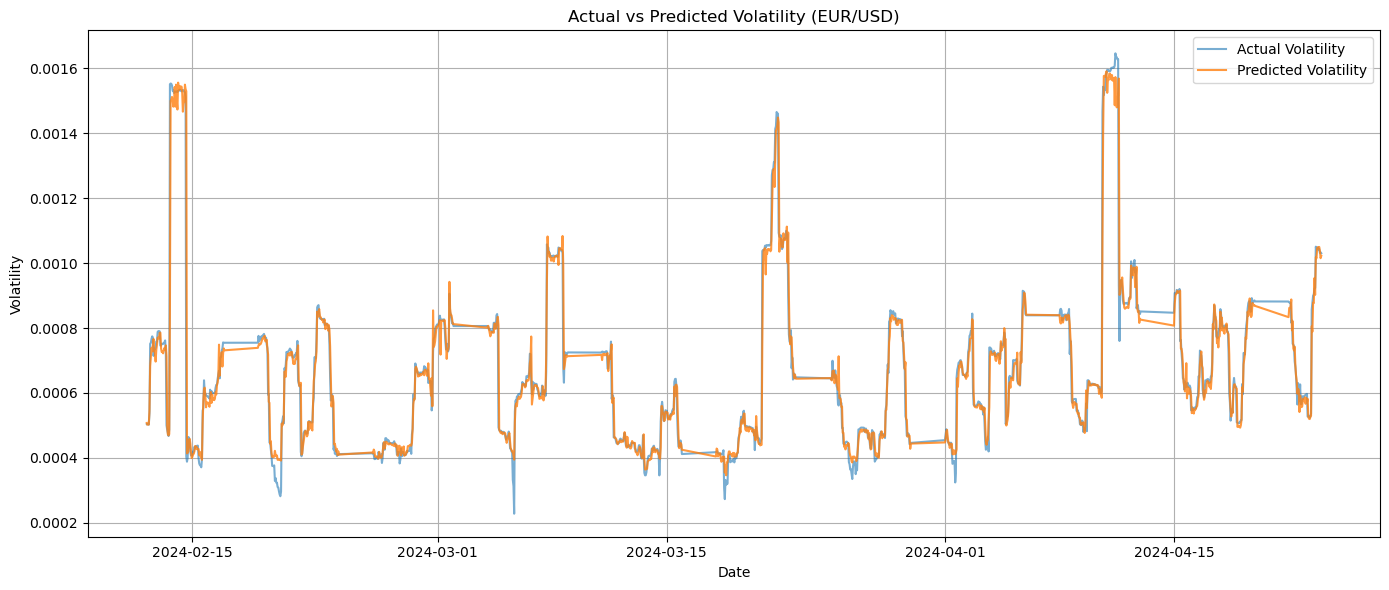

In [7]:
import matplotlib.pyplot as plt

# Add predictions back to test set
df_results = df_model.iloc[split_index:].copy()
df_results['predicted_volatility'] = y_pred

# Trade signals
df_results['signal'] = 0
df_results.loc[(df_results['predicted_volatility'] < df_results['predicted_volatility'].quantile(0.25)) &
               (df_results['rsi'] < 30), 'signal'] = 1  # Buy
df_results.loc[(df_results['predicted_volatility'] < df_results['predicted_volatility'].quantile(0.25)) &
               (df_results['rsi'] > 70), 'signal'] = -1  # Sell

# Plot predicted vs actual volatility
plt.figure(figsize=(14, 6))
plt.plot(df_results.index, df_results['volatility'], label='Actual Volatility', alpha=0.6)
plt.plot(df_results.index, df_results['predicted_volatility'], label='Predicted Volatility', alpha=0.8)
plt.title("Actual vs Predicted Volatility (EUR/USD)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


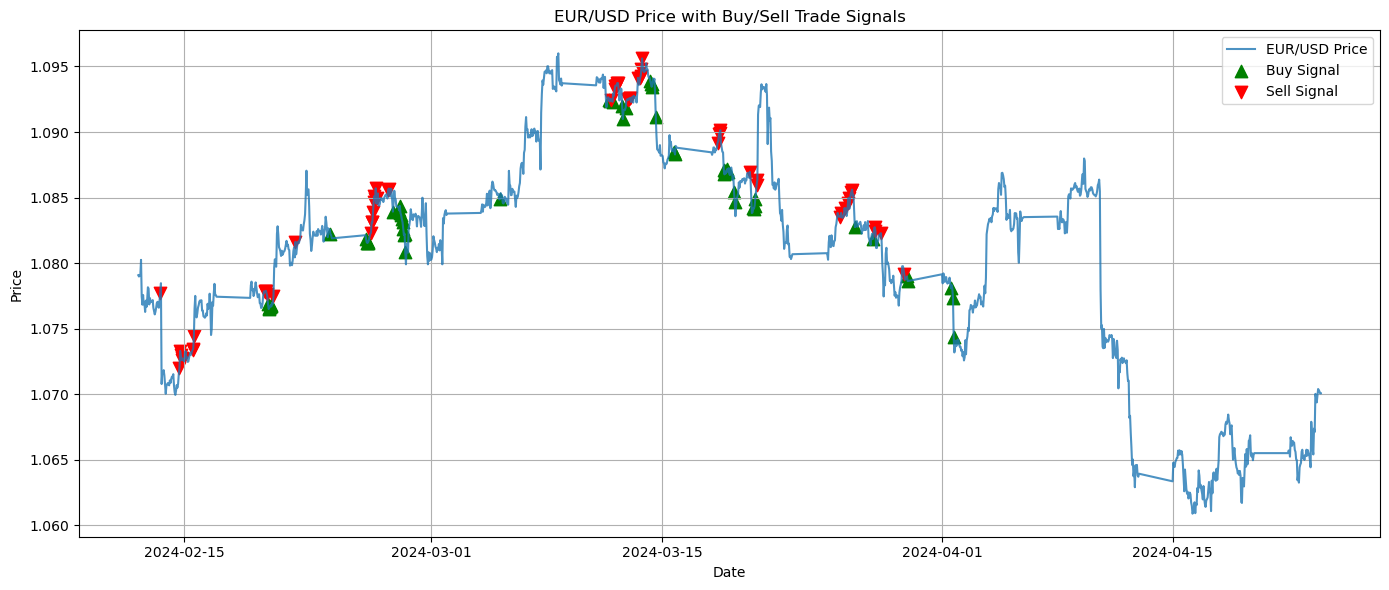

In [8]:
# Plot price with trade signals
plt.figure(figsize=(14, 6))
plt.plot(df_results.index, df_results['close_eurusd'], label='EUR/USD Price', alpha=0.8)

# Plot Buy signals
buy_signals = df_results[df_results['signal'] == 1]
plt.scatter(buy_signals.index, buy_signals['close_eurusd'], marker='^', color='green', label='Buy Signal', s=80)

# Plot Sell signals
sell_signals = df_results[df_results['signal'] == -1]
plt.scatter(sell_signals.index, sell_signals['close_eurusd'], marker='v', color='red', label='Sell Signal', s=80)

plt.title("EUR/USD Price with Buy/Sell Trade Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Forex Volatility Prediction with Strategy Suggestions

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "forex_1year.csv"  # Adjust path if needed
df = pd.read_csv(file_path)

# Combine date and time into datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['clock'])
df.set_index('datetime', inplace=True)

# Feature Engineering: Calculate returns and volatility
df['return_eurusd'] = np.log(df['close_eurusd'] / df['close_eurusd'].shift(1))
df['volatility'] = df['return_eurusd'].rolling(window=24).std()
df.dropna(inplace=True)

# Define features and target
feature_cols = [col for col in df.columns if any(x in col for x in ['open', 'high', 'low', 'close', 'tikvol'])]
X = df[feature_cols]
y = df['volatility']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
# Time-based split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Prediction & Strategy Suggestion Function
def predict_volatility_and_strategy(input_data: dict):
    """
    input_data: dict with keys matching the feature_cols (e.g., 'open_eurusd', 'close_eurusd', ...)
    """
    input_df = pd.DataFrame([input_data])
    input_scaled = scaler.transform(input_df[feature_cols])
    predicted_vol = model.predict(input_scaled)[0]

    # Strategy suggestion
    if predicted_vol > 0.001:
        strategy = "High volatility expected. Consider breakout strategies (e.g., Bollinger Band breakout, momentum trades)."
    elif predicted_vol > 0.0005:
        strategy = "Moderate volatility expected. Use range trading with tight stops."
    else:
        strategy = "Low volatility expected. Avoid trading or use mean-reversion strategies cautiously."

    return predicted_vol, strategy

# Example usage (using the most recent row of data)
latest_input = df[feature_cols].iloc[-1].to_dict()
predicted_vol, strategy = predict_volatility_and_strategy(latest_input)
print(f"Predicted Volatility: {predicted_vol}")
print(f"Suggested Strategy: {strategy}")

Mean Squared Error: 1.351327684667599e-07
Predicted Volatility: 0.0009033205277723174
Suggested Strategy: Moderate volatility expected. Use range trading with tight stops.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
# Forex Volatility Prediction per Currency Pair (Gradio Frontend with Graphs)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gradio as gr

# Load dataset
file_path = "forex_1year.csv"
df = pd.read_csv(file_path)

# Combine datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['clock'])
df.set_index('datetime', inplace=True)

# Calculate returns and volatility for each pair
volatility_data = {}
pairs = ['eurusd', 'audusd', 'eurgbp', 'gbpusd', 'nzdusd', 'usdchf', 'usdjpy']
models = {}
scalers = {}

for pair in pairs:
    df[f'return_{pair}'] = np.log(df[f'close_{pair}'] / df[f'close_{pair}'].shift(1))
    df[f'volatility_{pair}'] = df[f'return_{pair}'].rolling(window=24).std()
    df.dropna(inplace=True)

    feature_cols = [f'open_{pair}', f'high_{pair}', f'low_{pair}', f'close_{pair}', f'tikvol_{pair}']
    X = df[feature_cols]
    y = df[f'volatility_{pair}']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    scalers[pair] = scaler
    models[pair] = model

# Prediction function with plot
def predict_volatility_and_strategy(currency_pair, open_p, high_p, low_p, close_p, tick_volume):
    pair = currency_pair.lower()
    if pair not in models:
        return "Unsupported currency pair", "Please select a supported pair", None

    input_df = pd.DataFrame([{f'open_{pair}': open_p, f'high_{pair}': high_p, f'low_{pair}': low_p, f'close_{pair}': close_p, f'tikvol_{pair}': tick_volume}])
    scaler = scalers[pair]
    model = models[pair]
    input_scaled = scaler.transform(input_df)
    predicted_vol = model.predict(input_scaled)[0]

    if predicted_vol > 0.001:
        strategy = "High volatility expected. Consider breakout strategies (e.g., Bollinger Band breakout, momentum trades)."
    elif predicted_vol > 0.0005:
        strategy = "Moderate volatility expected. Use range trading with tight stops."
    else:
        strategy = "Low volatility expected. Avoid trading or use mean-reversion strategies cautiously."

    # Plot past volatility
    plt.figure(figsize=(10, 4))
    df[f'volatility_{pair}'].tail(100).plot(title=f"Recent Volatility for {currency_pair.upper()}")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("volatility_plot.png")
    plt.close()

    return f"Predicted Volatility: {predicted_vol:.6f}", strategy, "volatility_plot.png"

# Gradio UI
currency_dropdown = gr.Dropdown(choices=["EURUSD", "AUDUSD", "EURGBP", "GBPUSD", "NZDUSD", "USDCHF", "USDJPY"], label="Select Currency Pair")
inputs = [
    currency_dropdown,
    gr.Number(label="Open Price"),
    gr.Number(label="High Price"),
    gr.Number(label="Low Price"),
    gr.Number(label="Close Price"),
    gr.Number(label="Tick Volume")
]
outputs = [
    gr.Textbox(label="Predicted Volatility"),
    gr.Textbox(label="Trading Strategy Suggestion"),
    gr.Image(label="Recent Volatility Graph")
]

app = gr.Interface(
    fn=predict_volatility_and_strategy,
    inputs=inputs,
    outputs=outputs,
    title="Forex Volatility Predictor",
    description="Select a currency pair and input its OHLC and volume to get volatility prediction, trading suggestions, and a visual of recent volatility."
)

app.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [11]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Forex Volatility Prediction per Currency Pair (Streamlit Frontend with Graphs)

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import streamlit as st

# Load dataset
file_path = "forex_1year.csv"
df = pd.read_csv(file_path)

# Combine datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['clock'])
df.set_index('datetime', inplace=True)

# Calculate returns and volatility for each pair
volatility_data = {}
pairs = ['eurusd', 'audusd', 'eurgbp', 'gbpusd', 'nzdusd', 'usdchf', 'usdjpy']
models = {}
scalers = {}

for pair in pairs:
    df[f'return_{pair}'] = np.log(df[f'close_{pair}'] / df[f'close_{pair}'].shift(1))
    df[f'volatility_{pair}'] = df[f'return_{pair}'].rolling(window=24).std()
    df.dropna(inplace=True)

    feature_cols = [f'open_{pair}', f'high_{pair}', f'low_{pair}', f'close_{pair}', f'tikvol_{pair}']
    X = df[feature_cols]
    y = df[f'volatility_{pair}']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    scalers[pair] = scaler
    models[pair] = model

# Streamlit App
st.title("Forex Volatility Predictor")
st.write("Select a currency pair and input its OHLC and tick volume to get volatility prediction and trading suggestions.")

currency_pair = st.selectbox("Select Currency Pair", ["EURUSD", "AUDUSD", "EURGBP", "GBPUSD", "NZDUSD", "USDCHF", "USDJPY"])
open_p = st.number_input("Open Price", format="%.5f")
high_p = st.number_input("High Price", format="%.5f")
low_p = st.number_input("Low Price", format="%.5f")
close_p = st.number_input("Close Price", format="%.5f")
tick_volume = st.number_input("Tick Volume", format="%.0f")

if st.button("Predict Volatility"):
    pair = currency_pair.lower()
    if pair not in models:
        st.error("Unsupported currency pair. Please select a valid one.")
    else:
        input_df = pd.DataFrame([{f'open_{pair}': open_p, f'high_{pair}': high_p, f'low_{pair}': low_p, f'close_{pair}': close_p, f'tikvol_{pair}': tick_volume}])
        scaler = scalers[pair]
        model = models[pair]
        input_scaled = scaler.transform(input_df)
        predicted_vol = model.predict(input_scaled)[0]

        if predicted_vol > 0.001:
            strategy = "High volatility expected. Consider breakout strategies (e.g., Bollinger Band breakout, momentum trades)."
        elif predicted_vol > 0.0005:
            strategy = "Moderate volatility expected. Use range trading with tight stops."
        else:
            strategy = "Low volatility expected. Avoid trading or use mean-reversion strategies cautiously."

        st.success(f"Predicted Volatility: {predicted_vol:.6f}")
        st.info(strategy)

        # Plot past volatility
        st.subheader(f"Recent Volatility Trend for {currency_pair}")
        fig, ax = plt.subplots(figsize=(10, 4))
        df[f'volatility_{pair}'].tail(100).plot(ax=ax, title=f"Recent Volatility for {currency_pair.upper()}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Volatility")
        ax.grid(True)
        st.pyplot(fig)


2025-05-13 08:30:03.774 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
